In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import plotly.express as px

project_folder = '/content/drive/MyDrive/ProjectTCNER'
data_folder = os.path.join(project_folder, "data")
trainset_file = os.path.join(data_folder, "DBLPTrainset.txt")
testset_file = os.path.join(data_folder, "DBLPTestset.txt")
ground_truth_file = os.path.join(data_folder, "DBLPTestGroundTruth.txt")

In [ ]:
dataset_train = pd.read_table(os.path.join(trainset_file), sep="\t", header=None, names=['Conference', 'Title'], index_col=0)
dataset_train

,Conference,Title
0,ISCAS,Scalable Serial-parallel Multiplier over GF(2m...
1,SIGGRAPH,Plenoptic sampling.
2,ISCAS,Sensitivity and uniformity of a 0.18micrometer...
3,WWW,A survey of web archive search architectures.
4,ISCAS,Understanding dynamic behavior of mm-wave CML ...
...,...,...
21638,ISCAS,Decoding a Family of Dense Codes using the Sum...
21639,VLDB,CoHadoop: Flexible Data Placement and Its Expl...
21640,ISCAS,Full system simulation with QEMU: An approach ...
21641,INFOCOM,Localization in non-localizable sensor and ad-...


In [ ]:
dataset_test = pd.read_table(os.path.join(testset_file), sep="\t", header=None, names=['Title'], index_col=0)
dataset_test

,Title
0,Fast recursive adaptation for nonlinear filters.
1,High-Throughput Data Compressor Designs Using ...
2,Functional Verification of ECL Circuits Includ...
3,Efficient network generation under general pre...
4,Creating the earth as a backdrop in <i>Gravity...
...,...
3368,GEM: A Geometric Algorithm for Scheduling.
3369,On the geographic patterns of a large-scale mo...
3370,NScale: Neighborhood-centric Analytics on Larg...
3371,Sufficient Conditions for Finding Multiple Ope...


In [ ]:
dataset_gt = pd.read_table(os.path.join(ground_truth_file), sep="\t", header=None, names=['Conference'], index_col=0)
dataset_gt

,Conference
0,ISCAS
1,ISCAS
2,ISCAS
3,WWW
4,SIGGRAPH
...,...
3368,ISCAS
3369,INFOCOM
3370,VLDB
3371,ISCAS


In [ ]:
dataset_test = pd.merge(dataset_test, dataset_gt, left_index=True, right_index=True)
dataset_test

,Title,Conference
0,Fast recursive adaptation for nonlinear filters.,ISCAS
1,High-Throughput Data Compressor Designs Using ...,ISCAS
2,Functional Verification of ECL Circuits Includ...,ISCAS
3,Efficient network generation under general pre...,WWW
4,Creating the earth as a backdrop in <i>Gravity...,SIGGRAPH
...,...,...
3368,GEM: A Geometric Algorithm for Scheduling.,ISCAS
3369,On the geographic patterns of a large-scale mo...,INFOCOM
3370,NScale: Neighborhood-centric Analytics on Larg...,VLDB
3371,Sufficient Conditions for Finding Multiple Ope...,ISCAS


In [ ]:
dataset_whole = pd.concat([dataset_train, dataset_test])
dataset_whole

,Conference,Title
0,ISCAS,Scalable Serial-parallel Multiplier over GF(2m...
1,SIGGRAPH,Plenoptic sampling.
2,ISCAS,Sensitivity and uniformity of a 0.18micrometer...
3,WWW,A survey of web archive search architectures.
4,ISCAS,Understanding dynamic behavior of mm-wave CML ...
...,...,...
3368,ISCAS,GEM: A Geometric Algorithm for Scheduling.
3369,INFOCOM,On the geographic patterns of a large-scale mo...
3370,VLDB,NScale: Neighborhood-centric Analytics on Larg...
3371,ISCAS,Sufficient Conditions for Finding Multiple Ope...


In [ ]:
dataset_whole['Conference'].value_counts()

Conference
ISCAS       9557
INFOCOM     4983
VLDB        3897
WWW         3715
SIGGRAPH    2864
Name: count, dtype: int64

In [ ]:
possible_labels = dataset_whole.Conference.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'ISCAS': 0, 'SIGGRAPH': 1, 'WWW': 2, 'INFOCOM': 3, 'VLDB': 4}

In [ ]:
dataset_whole['label'] = dataset_whole.Conference.replace(label_dict)

In [ ]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(dataset_whole.index.values,
                                                  dataset_whole.label.values,
                                                  test_size=0.15,
                                                  random_state=42,
                                                  stratify=dataset_whole.label.values)

dataset_whole['data_type'] = ['not_set']*dataset_whole.shape[0]

dataset_whole.loc[X_train, 'data_type'] = 'train'
dataset_whole.loc[X_val, 'data_type'] = 'val'

dataset_whole.groupby(['Conference', 'label', 'data_type']).count()

Title
Conference label data_type       
INFOCOM    3     train       4098
                 val          885
ISCAS      0     train       7700
                 val         1857
SIGGRAPH   1     train       2354
                 val          510
VLDB       4     train       3195
                 val          702
WWW        2     train       3038
                 val          677

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

encoded_data_train = tokenizer.batch_encode_plus(
    dataset_whole[dataset_whole.data_type=='train'].Title.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    dataset_whole[dataset_whole.data_type=='val'].Title.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(dataset_whole[dataset_whole.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(dataset_whole[dataset_whole.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 3

dataloader_train = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val,
                                   sampler=SequentialSampler(dataset_val),
                                   batch_size=batch_size)

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5,
                  eps=1e-8)

epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [ ]:
import random
import numpy as np

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

for epoch in tqdm(range(1, epochs+1)):

    model.train()

    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})


    torch.save(model.state_dict(), f'data_volume/finetuned_BERT_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

model.load_state_dict(torch.load('data_volume/finetuned_BERT_epoch_1.model', map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)

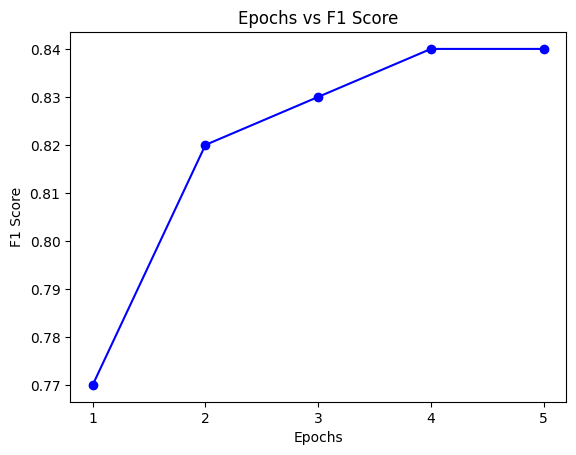

In [ ]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3, 4, 5]
f1_scores = [0.77, 0.82, 0.83, 0.84, 0.84]

plt.plot(epochs, f1_scores, marker='o', color='b', linestyle='-')
plt.title('Epochs vs F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.xticks(epochs)
plt.show()


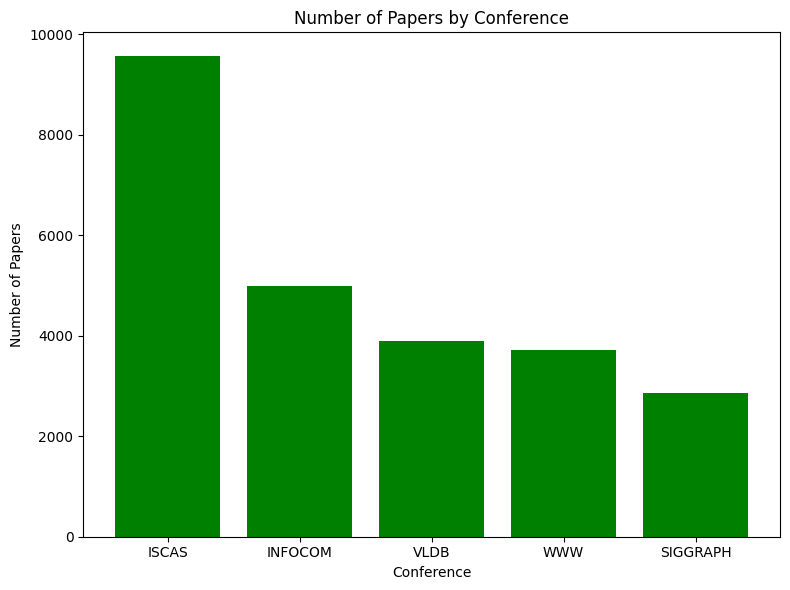

In [ ]:
import matplotlib.pyplot as plt

conferences = ['ISCAS', 'INFOCOM', 'VLDB', 'WWW', 'SIGGRAPH']
papers_count = [9557, 4983, 3897, 3715, 2864]

plt.figure(figsize=(8, 6))
plt.bar(conferences, papers_count, color='green')

plt.xlabel('Conference')
plt.ylabel('Number of Papers')
plt.title('Number of Papers by Conference')

plt.tight_layout()
plt.show()


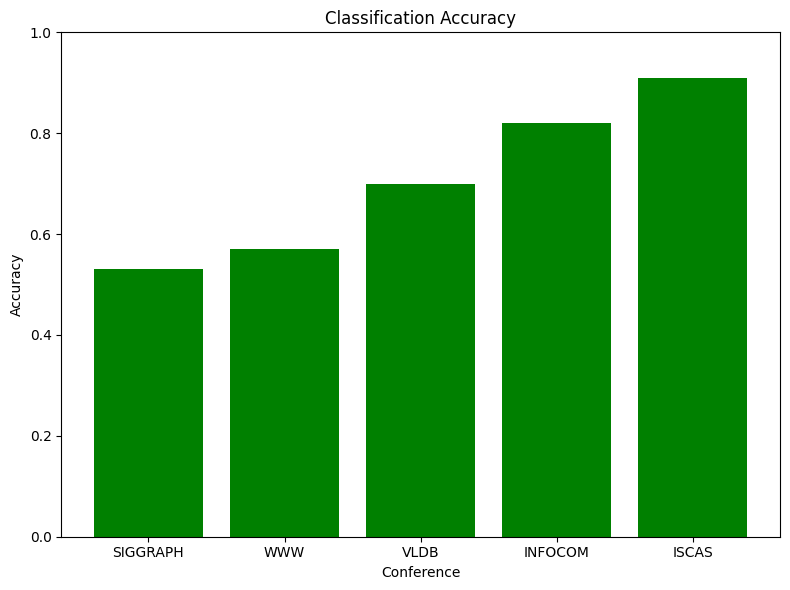

In [ ]:
import matplotlib.pyplot as plt

conference_names = ['SIGGRAPH', 'WWW', 'VLDB', 'INFOCOM', 'ISCAS']
scores = [0.53, 0.57, 0.70, 0.82, 0.91]

plt.figure(figsize=(8, 6))
plt.bar(conference_names, scores, color='green')

plt.xlabel('Conference')
plt.ylabel('Accuracy')
plt.title('Classification Accuracy')

plt.ylim(0, 1)
plt.tight_layout()
plt.show()
